In [1]:
#importing necesssary apis
import pandas as pd
import tensorflow as tf
import numpy as np
import torch
from os import walk
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GRU,LSTM,Concatenate,Dense,Dropout,Flatten
from tensorflow.keras import Model

In [2]:
#Creating the lists of features from the given pickle files
place=[]
cast=[]
action=[]
audio=[]
y=[]

datapath="data/"
filenames=[]
for (_,_,filename) in walk(datapath):
    filenames.extend(filename)

for f in filenames:
    df=pd.read_pickle(datapath+f)
    a=df['place']
    b=df['cast']
    c=df['action']
    d=df['audio']
    place.append(a)
    cast.append(b)
    action.append(c)
    audio.append(d)
    y.append(df['scene_transition_boundary_ground_truth'])

In [3]:
#padding the features to have equal lengths for all movies
place=tf.keras.preprocessing.sequence.pad_sequences(
    place, padding="post", dtype="float32"
)
cast=tf.keras.preprocessing.sequence.pad_sequences(
    cast, padding="post", dtype="float32"
)
action=tf.keras.preprocessing.sequence.pad_sequences(
    action, padding="post", dtype="float32"
)
audio=tf.keras.preprocessing.sequence.pad_sequences(
    audio, padding="post", dtype="float32"
)
y=tf.keras.preprocessing.sequence.pad_sequences(
    y, padding="post", dtype="int32", value=0
)
placeTrain,placeTest,castTrain,castTest,actionTrain,actionTest,audioTrain,audioTest, yTrain, yTest = train_test_split(place, cast, action, audio, y, test_size=0.10, random_state=123)

In [4]:
#Defining th2 framework using GRU layers for each and concatenating the results to give prediction
def buildModel(place,cast,action,audio,y):
    dropout=Dropout(0.3)
    place=keras.Input(shape=place[0].shape)
    cast=keras.Input(shape=cast[0].shape)
    action=keras.Input(shape=action[0].shape)
    audio=keras.Input(shape=audio[0].shape)

    placeLayers=GRU(512, return_sequences=False)(place)
    placeLayers=dropout(placeLayers)
    placeLayers=Flatten()(placeLayers)
    castLayers=GRU(128, return_sequences=False)(cast)
    castLayers=dropout(castLayers)
    castLayers=Flatten()(castLayers)
    actionLayers=GRU(128, return_sequences=False)(action)
    actionLayers=dropout(actionLayers)
    actionLayers=Flatten()(actionLayers)
    audioLayers=GRU(128, return_sequences=False)(audio)
    audioLayers=dropout(audioLayers)
    audioLayers=Flatten()(audioLayers)

    output=Concatenate()([placeLayers,castLayers,actionLayers,audioLayers,])
    output=(Dense(len(y[0]),activation="sigmoid",name="L3")(output))

    model=Model(inputs=[place,cast,action,audio],outputs=[output])
    model.compile(optimizer='sgd',loss='binary_crossentropy',metrics=["binary_accuracy"])

    return model

In [17]:
#building the model using defined network
rnn=buildModel(placeTrain,castTrain,actionTrain,audioTrain,yTrain)
history=rnn.fit(
    [
        placeTrain,
        castTrain,
        actionTrain,
        audioTrain,
    ],
    [
        yTrain,
    ],
    validation_data=(
        [
            placeTest,
            castTest,
            actionTest,
            audioTest,
        ],
        [
            yTest,
        ]
    ),
    epochs=20,
    batch_size=4
)

Epoch 1/20
15/15 [==============================] - 803s 52s/step - loss: 0.6934 - binary_accuracy: 0.8458 - val_loss: 0.6931 - val_binary_accuracy: 0.8776
Epoch 2/20
15/15 [==============================] - 923s 63s/step - loss: 0.6932 - binary_accuracy: 0.8287 - val_loss: 0.6931 - val_binary_accuracy: 0.8745
Epoch 3/20
15/15 [==============================] - 1015s 68s/step - loss: 0.6933 - binary_accuracy: 0.8280 - val_loss: 0.6931 - val_binary_accuracy: 0.8739
Epoch 4/20
15/15 [==============================] - 930s 61s/step - loss: 0.6932 - binary_accuracy: 0.8291 - val_loss: 0.6931 - val_binary_accuracy: 0.8744
Epoch 5/20
15/15 [==============================] - 1065s 71s/step - loss: 0.6933 - binary_accuracy: 0.8214 - val_loss: 0.6931 - val_binary_accuracy: 0.8755
Epoch 6/20
15/15 [==============================] - 1098s 73s/step - loss: 0.6931 - binary_accuracy: 0.8328 - val_loss: 0.6930 - val_binary_accuracy: 0.8755
Epoch 7/20
15/15 [==============================] - 1012s 67s

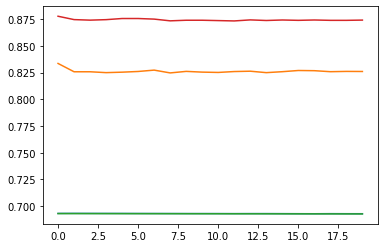

In [21]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'])
# pyplot.plot(history.history['binary_accuracy'])
# pyplot.plot(history.history['val_loss'])
# pyplot.plot(history.history['val_binary_accuracy'])
pyplot.show()

In [19]:
#Saving the results by in data-final folder.
import tensorflow as tf
import pickle
from os import walk

datapath="data/"
datapath1="data-final/"
filenames=[]
for (_,_,filename) in walk(datapath):
    filenames.extend(filename)

for f in filenames:
    df=pd.read_pickle(datapath+f)
    placedim=df['place'].shape
    castdim=df['cast'].shape
    actiondim=df['action'].shape
    audiodim=df['audio'].shape

    placepaddings = tf.constant([[0, 3096-placedim[0]], [0, 0]])
    df_place=tf.pad(df['place'],placepaddings,"CONSTANT")
    df_place=tf.reshape(df_place,[1,df_place.shape[0],df_place.shape[1]])

    castpaddings = tf.constant([[0, 3096-castdim[0]], [0, 0]])
    df_cast=tf.pad(df['cast'],castpaddings,"CONSTANT")
    df_cast=tf.reshape(df_cast,[1,df_cast.shape[0],df_cast.shape[1]])

    actionpaddings = tf.constant([[0, 3096-actiondim[0]], [0, 0]])
    df_action=tf.pad(df['action'],actionpaddings,"CONSTANT")
    df_action=tf.reshape(df_action,[1,df_action.shape[0],df_action.shape[1]])

    audiopaddings = tf.constant([[0, 3096-audiodim[0]], [0, 0]])
    df_audio=tf.pad(df['audio'],audiopaddings,"CONSTANT")
    df_audio=tf.reshape(df_audio,[1,df_audio.shape[0],df_audio.shape[1]])

    x=rnn.predict([df_place,df_cast,df_action,df_audio],steps=1)
    x=tf.reshape(x,[x.shape[1]])

    df['scene_transition_boundary_prediction']=np.array(x[0:len(df['scene_transition_boundary_prediction'])])

    pickle.dump(df, open(datapath1+f, "wb" ) )